In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import statsmodels.api as sm
import statsmodels.formula.api as smf

C:\Users\Kenneth\Miniconda3\envs\clearbrain_lastresort\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# Data 6

In [2]:
# Read in
df6 = pd.read_csv('../data/df6.csv')

In [3]:
# Inspect
df6.head()

,x,y
0,2.218651,1.184560
1,2.906897,3.216393
2,3.057199,3.676579
3,3.138405,2.588413
4,3.076162,1.272983


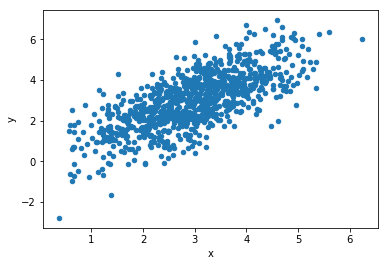

In [4]:
# Plot
df6.plot('x', 'y', kind='scatter')

In [5]:
# Data looks straight-forward.  Fit a simple model again
model6 = smf.ols(
    formula='y ~ x',
    data=df6
)
model6_fit = model6.fit()

C:\Users\Kenneth\Miniconda3\envs\clearbrain_lastresort\lib\site-packages\statsmodels\base\data.py:480: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if hasattr(x, 'ix'):


In [6]:
# Summarize
model6_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     944.2
Date:                Thu, 28 May 2020   Prob (F-statistic):          2.86e-142
Time:                        21:52:27   Log-Likelihood:                -1248.8
No. Observations:                 900   AIC:                             2502.
Df Residuals:                     898   BIC:                             2511.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0718      0.100      0.718      0.473      -0.124       0.268
x              0.9851      0.032     30.728      0.000       0.922       1.048
==============================================================================
Omnibus:                        1.083   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.582   Jarque-Bera (JB):                1.101
Skew:                          -0.084   Prob(JB):                        0.577
Kurtosis:                       2.968   Cond. No.                         10.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Only 900 rows in the regression, was that everything?

In [7]:
df6.shape

(1000, 2)

Nope, must be null values.  In Python, these are usually np.NaN values but be careful because they could take other values as well.

In [8]:
# See if any np.NaNs
df6[df6['x'].isnull()].head()

,x,y
5,NaN,-1.738836
8,NaN,-2.859447
31,NaN,-0.802285
66,NaN,0.105282
68,NaN,-2.081959


In [9]:
# How many of these?
df6[df6['x'].isnull()].shape

(100, 2)

Looks like these are to blame, because statsmodels does not handle them natively.  Here we are at an important crossroads and need to answer this question: **Do we care about these missing x values?**

- If yes, then we need to find a way to model them.  There are a number of ways to do this, including but not limited to:
    - Fit two separate models, one for nulls and one for non-nulls  
    - Find a clever way to incorporate them into a single regression (which is obviously what we're going to choose here)
- If no, then we can simply filter them out.  But in Derek's opinion you should very rarely do this because this "missingness" usually means something like important, such as an error in the data collection or data aggregation/merging process.

Here, let's include them and find a way to be clever.  Let's define what an interpretable regression formula could look like.  Without nulls, we have something like this

```
y_est = Intercept + B_1 * x
```

And since we only have one variable, it would nice to be able to measure the "effect" of having a missing `x` value.  Which means we need to have an indicator of `x` being missing:

```
y_est = Intercept + B_1 * x + B_2 * (x is null)
```

That indicator is easy to define, but what `x` value do we assign them.  One option is to assign them a value not in the range of our `x` values, like -99, to make the extemely obvious.  This means that, for missing `x` values, the model translates to this:

```
y_est = Intercept + B_1 * -99 + B_2
```

Which, frankly, is not directly intuitive unless you can quickly do that math in your head.  However, what if instead we set x to be 0 when `x` is null?  Unfortunately this overlaps close to non-null `x` values, but makes the regression much more directly interpretable:

```
y_est = Intercept + B_1 * 0 + B_2
y_est = Intercept           + B_2
```

I.e. `B_2` is the average effect if `x` is null.

Let's code it up.

In [10]:
def make_x_0_if_null(x):
    return [0 if np.isnan(a) else a for a in x]

def create_x_null_ind(x):
    return [0 if np.isnan(a) else 1 for a in x]

In [11]:
# Fit model
model6_x_null_ind = smf.ols(
    formula='y ~ make_x_0_if_null(x) + create_x_null_ind(x)',
    data=df6
)
model6_x_null_ind_fit = model6_x_null_ind.fit()

In [12]:
# Summarize
model6_x_null_ind_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     1215.
Date:                Thu, 28 May 2020   Prob (F-statistic):          4.67e-268
Time:                        21:52:27   Log-Likelihood:                -1386.6
No. Observations:                1000   AIC:                             2779.
Df Residuals:                     997   BIC:                             2794.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.9602      0.097     -9.902      0.000      -1.150      -0.770
make_x_0_if_null(x)      0.9851      0.032     30.744      0.000       0.922       1.048
create_x_null_ind(x)     1.0320      0.139      7.411      0.000       0.759       1.305
==============================================================================
Omnibus:                        0.846   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.655   Jarque-Bera (JB):                0.885
Skew:                          -0.069   Prob(JB):                        0.642
Kurtosis:                       2.956   Cond. No.                         16.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Looks like we have every row, and off-hand fit looks reasonable.  For sanity, let's visualize this data set being modelled.

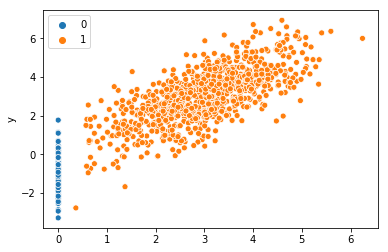

In [13]:
# Inspect
sb.scatterplot(x=make_x_0_if_null(df6['x']), y=df6['y'], hue=create_x_null_ind(df6['x']))

It looks like this made a nice line!

However, does it really matter which value we pick for x?  Let's find out.

In [14]:
def sim_null_x_value(k):
    def impute_x(x, k):
        return [k if np.isnan(a) else a for a in x]
    
    # Fit model
    model6_impute_x = smf.ols(
        formula='y ~ impute_x(x, k) + create_x_null_ind(x)',
        data=df6
    )
    
    return model6_impute_x.fit()

In [15]:
# Sample 10 random and rounded imputation values from -100 to 100.  And sort it for easier inspection.
np.random.seed(666)
mesh = np.rint(np.random.uniform(-100, 100, 10))
mesh = np.sort(mesh)

df_prediction = pd.DataFrame()

for i, k in enumerate(mesh):
    # Generate fit
    loop_model_fit = sim_null_x_value(k)
    
    # Add predictios as a column to the prediction df
    df_prediction[f'impute_{k}'] = loop_model_fit.predict(df6)
    
# Inspect
df_prediction.head()

,impute_-97.0,impute_-90.0,impute_-80.0,impute_-17.0,impute_2.0,impute_35.0,impute_40.0,impute_46.0,impute_69.0,impute_90.0
0,2.257359,2.257359,2.257359,2.257359,2.257359,2.257359,2.257359,2.257359,2.257359,2.257359
1,2.935348,2.935348,2.935348,2.935348,2.935348,2.935348,2.935348,2.935348,2.935348,2.935348
2,3.083411,3.083411,3.083411,3.083411,3.083411,3.083411,3.083411,3.083411,3.083411,3.083411
3,3.163406,3.163406,3.163406,3.163406,3.163406,3.163406,3.163406,3.163406,3.163406,3.163406
4,3.102091,3.102091,3.102091,3.102091,3.102091,3.102091,3.102091,3.102091,3.102091,3.102091


All these predictions look the same.  Do a quick correlation check.

In [16]:
df_prediction.corr()

,impute_-97.0,impute_-90.0,impute_-80.0,impute_-17.0,impute_2.0,impute_35.0,impute_40.0,impute_46.0,impute_69.0,impute_90.0
impute_-97.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
impute_-90.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
impute_-80.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
impute_-17.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
impute_2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
impute_35.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
impute_40.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
impute_46.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
impute_69.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
impute_90.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Perfect Pearson correlation, so exactly the same predictions.

If you're confused about this, I encourage you to pick a couple of these potential values, build the regresion, and write out the predictions for some rows to understand what is happening.  tl;dr the regression is picking up on whatever value you use, and imputing `x` to be 0 makes the regression way easier to interpret than non-0 values!

# Data 7

In [17]:
# Read in
df7 = pd.read_csv('../data/df7.csv')

In [18]:
# Inspect
df7.head()

,x,y
0,A,-0.437663
1,NaN,-2.953738
2,A,1.267236
3,B,2.445026
4,B,0.525157


Aha!  Here we happened to see a missig value right off the bat.

Categoricals are much easier when it comes to dealing with missing values.  Missing values never overlap with another value, so we can think of them as just another "level" like the other value.  But generally I like to change them to some string value because not all modelling frameworks support missing values.  Here, let's just change np.NaN to "Missing".

np.NaNs for string columns can be messy because the same logic for numerical varaibles don't apply.  We have a few options:

- Modify our read function to not convert specific values to np.NaN (here it's an empty string)
- Use `.fillna()`

For simplicity we'll just use the latter here.

In [19]:
def make_x_missing_if_null(x):
    return x.fillna('Missing')

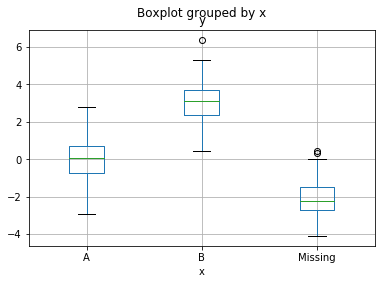

In [20]:
# Visualize
df7.fillna('Missing').boxplot('y', by='x')

In [21]:
# Fit model
model7_x_missing = smf.ols(
    formula='y ~ make_x_missing_if_null(x)',
    data=df7
)
model7_x_missing_fit = model7_x_missing.fit()

In [22]:
# Summarize
model7_x_missing_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     1713.
Date:                Thu, 28 May 2020   Prob (F-statistic):          2.96e-323
Time:                        21:52:28   Log-Likelihood:                -1394.0
No. Observations:                1000   AIC:                             2794.
Df Residuals:                     997   BIC:                             2809.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.0248      0.047      0.530      0.596      -0.067       0.117
make_x_missing_if_null(x)[T.B]           2.9976      0.065     45.932      0.000       2.870       3.126
make_x_missing_if_null(x)[T.Missing]    -2.1427      0.107    -20.017      0.000      -2.353      -1.933
==============================================================================
Omnibus:                        8.316   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                6.075
Skew:                           0.061   Prob(JB):                       0.0480
Kurtosis:                       2.638   Cond. No.                         4.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So the general order of effect looks to be Missing -> A -> B.  Is it possible to make the reference value "Missing" (then A, then B) to have a monotonic measured effect?

Let's try pandas Categorical type.

In [23]:
def make_x_categorical_with_missing_reference(x):
    return pd.Categorical(x.fillna('Missing'), categories=['Missing', 'A', 'B'])

In [24]:
# Fit model
smf.ols(
    formula='y ~ make_x_categorical_with_missing_reference(x)',
    data=df7
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     1713.
Date:                Thu, 28 May 2020   Prob (F-statistic):          2.96e-323
Time:                        21:52:28   Log-Likelihood:                -1394.0
No. Observations:                1000   AIC:                             2794.
Df Residuals:                     997   BIC:                             2809.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                            -2.1179      0.096    -22.003      0.000      -2.307      -1.929
make_x_categorical_with_missing_reference(x)[T.A]     2.1427      0.107     20.017      0.000       1.933       2.353
make_x_categorical_with_missing_reference(x)[T.B]     5.1403      0.106     48.292      0.000       4.931       5.349
==============================================================================
Omnibus:                        8.316   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                6.075
Skew:                           0.061   Prob(JB):                       0.0480
Kurtosis:                       2.638   Cond. No.                         6.59
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Looks like it worked!

However, generally I prefer to have "Missing" be the *last* category (like it was by default here) so that the effect of being missing can be clearly identified.  Otherwise, just looking at the coefficients wouldn't make it obvious that there were missing value.

# Data 8

In [25]:
# Read in
df8 = pd.read_csv('../data/df8.csv')

In [26]:
# Inspect
df8.head()

,x1,x2,y
0,2.689212,C,2.194307
1,1.770311,A,4.538295
2,2.884945,B,1.717667
3,3.007989,C,5.219927
4,4.959291,A,7.623335


Two predictors, one numeric and one categorical.  Let's visualize them separately.

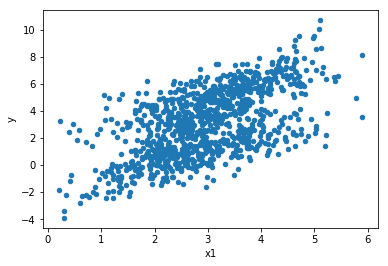

In [27]:
# Visualize x1
df8.plot('x1', 'y', kind='scatter')

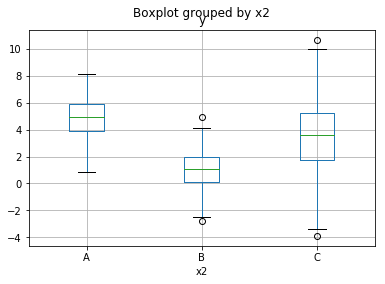

In [28]:
# Visualize x2
df8.boxplot('y', by='x2')

Looks relatively linear in x1, x2 values seem to have different means.  Let's fit it all.

In [29]:
# Fit model
model8 = smf.ols(
    formula='y ~ x1 + x2',
    data=df8
)
model8_fit = model8.fit()

In [30]:
# Summarize
model8_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     1124.
Date:                Thu, 28 May 2020   Prob (F-statistic):          3.68e-319
Time:                        21:52:28   Log-Likelihood:                -1571.2
No. Observations:                1000   AIC:                             3150.
Df Residuals:                     996   BIC:                             3170.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5821      0.127      4.581      0.000       0.333       0.832
x2[T.B]       -3.8628      0.091    -42.428      0.000      -4.041      -3.684
x2[T.C]       -1.4110      0.091    -15.497      0.000      -1.590      -1.232
x1             1.4525      0.037     39.261      0.000       1.380       1.525
==============================================================================
Omnibus:                        1.410   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.494   Jarque-Bera (JB):                1.280
Skew:                           0.054   Prob(JB):                        0.527
Kurtosis:                       3.138   Cond. No.                         13.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Fit seems reasonable, all effects significant.  Let's break out that univariate code again.

In [31]:
def plot_univariate(df, x, y, model_fit):
    # Add prediction
    df = df.assign(p = model_fit.predict(df))
    
    # If x is numeric, bin into 5 groups
    if df[x].dtype in (np.int64, np.float64):
        df[x] = pd.cut(df[x], 5).apply(str)
    
    # Aggregate
    df_agg = (
        df
        .groupby(x)
        .agg(
            n=(y, 'count'),
            y_mean=(y, 'mean'),
            p_mean=('p', 'mean'),
        )
        .reset_index()
    )
    
    print(df_agg)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
    
    # First plot: Counts
    ax1.bar(x, 'n', data=df_agg)
    
    # Second plot: Average actuals and predicted
    ax2.scatter(x, 'y_mean', data=df_agg, label='Actual', marker='.', color='green', linewidth=3)
    ax2.scatter(x, 'p_mean', data=df_agg, label='Predicted', marker='.', color='red', linewidth=3)
    
    plt.legend()
    plt.show()

               x1    n    y_mean    p_mean
0  (0.194, 1.339]   53  0.071495  0.135551
1  (1.339, 2.478]  267  1.693538  1.745771
2  (2.478, 3.617]  411  3.251823  3.189245
3  (3.617, 4.756]  237  4.618808  4.600518
4  (4.756, 5.895]   32  5.897054  6.294334


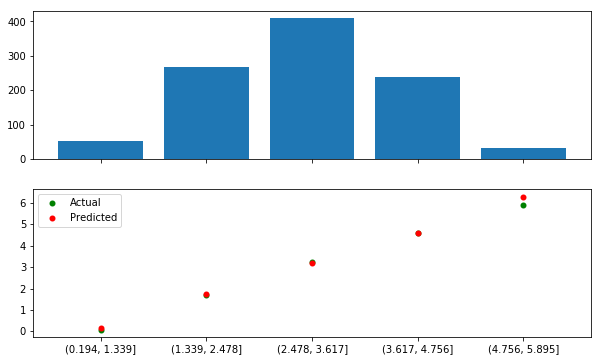

In [32]:
# x1
plot_univariate(df8, 'x1', 'y', model8_fit)

  x2    n    y_mean    p_mean
0  A  316  4.853987  4.853987
1  B  342  1.025649  1.025649
2  C  342  3.483024  3.483024


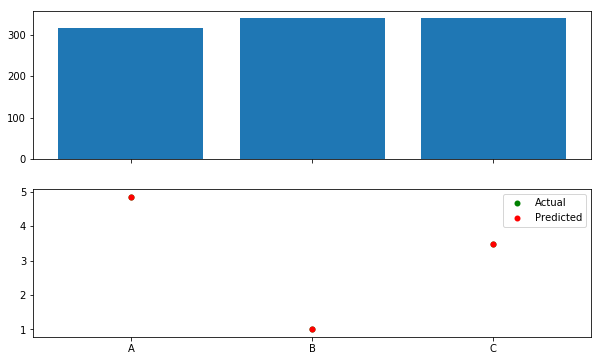

In [33]:
# x2
plot_univariate(df8, 'x2', 'y', model8_fit)

Looks pretty reasonable!  However, since we only have two variables, let's see if there's any interaction going on.

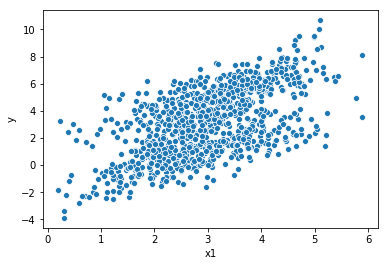

In [34]:
# Regraph x1
sb.scatterplot(data=df8, x='x1', y='y')

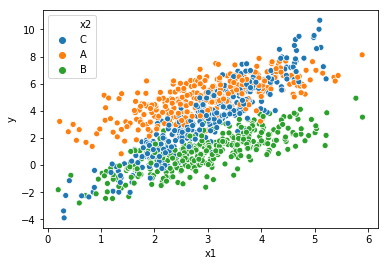

In [35]:
# Color by x2
# Inspect by x2 value
sb.scatterplot(data=df8, x='x1', y='y', hue='x2')

Ah, it does look a bit different for each category.  Let's see how some interaction terms play out.

In [36]:
# Fit model
model8_int = smf.ols(
    formula='y ~ x1*x2',
    data=df8
)
model8_int_fit = model8_int.fit()

In [37]:
# Summarize
model8_int_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     1104.
Date:                Thu, 28 May 2020   Prob (F-statistic):               0.00
Time:                        21:52:29   Log-Likelihood:                -1370.6
No. Observations:                1000   AIC:                             2753.
Df Residuals:                     994   BIC:                             2783.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9916      0.163     12.188      0.000       1.671       2.312
x2[T.B]       -3.9917      0.229    -17.447      0.000      -4.441      -3.543
x2[T.C]       -5.7565      0.235    -24.533      0.000      -6.217      -5.296
x1             0.9733      0.052     18.549      0.000       0.870       1.076
x1:x2[T.B]     0.0473      0.073      0.646      0.518      -0.096       0.191
x1:x2[T.C]     1.4683      0.075     19.503      0.000       1.321       1.616
==============================================================================
Omnibus:                        0.978   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.613   Jarque-Bera (JB):                1.045
Skew:                          -0.040   Prob(JB):                        0.593
Kurtosis:                       2.864   Cond. No.                         40.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Oh wow, off-hand that looks like a much better fit!

It looks like the only coefficient that is not signficant is the x1 * x2 = B term.  This is because x2 = A is the reference category, and looking at the graph above it looks like A and B have close to the same slope.

               x1    n    y_mean    p_mean
0  (0.194, 1.339]   53  0.071495  0.148461
1  (1.339, 2.478]  267  1.693538  1.728830
2  (2.478, 3.617]  411  3.251823  3.197196
3  (3.617, 4.756]  237  4.618808  4.621825
4  (4.756, 5.895]   32  5.897054  6.154386


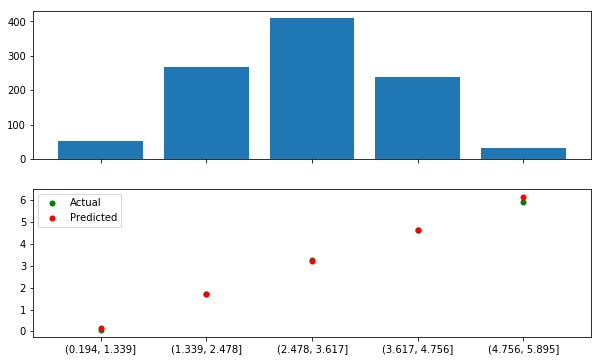

In [38]:
# Redo x1 univariate
plot_univariate(df8, 'x1', 'y', model8_int_fit)

  x2    n    y_mean    p_mean
0  A  316  4.853987  4.853987
1  B  342  1.025649  1.025649
2  C  342  3.483024  3.483024


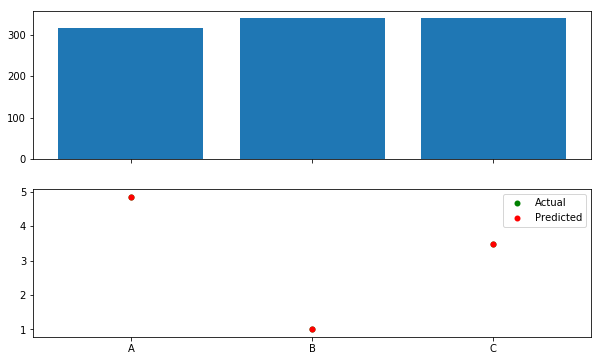

In [39]:
# Redo x2 univariate
plot_univariate(df8, 'x2', 'y', model8_int_fit)

It's a bit hard to tell, but the univariates do look a bit better as well.  The `x1` values (stitched manually):

```
               x1    n    y_mean  original interaction
0  (0.194, 1.339]   53  0.071495  0.135551    0.148461
1  (1.339, 2.478]  267  1.693538  1.745771    1.728830
2  (2.478, 3.617]  411  3.251823  3.189245    3.197196
3  (3.617, 4.756]  237  4.618808  4.600518    4.621825
4  (4.756, 5.895]   32  5.897054  6.294334    6.154386
```

And the `x2` values (which look the same, which can happen because the interaction terms helped the x1 effects more than the x2 effects):

```
  x2    n    y_mean  original interaction
0  A  316  4.853987  4.853987    4.853987
1  B  342  1.025649  1.025649    1.025649
2  C  342  3.483024  3.483024    3.483024
```